# Whole-brain recordings of spontaneous activity of larval zebrafish 

Light-sheet fluorescence microscopy is a novel imaging method for simultaneously recording the activity of whole brains of small vertebrae (larval zebrafish) at neuron scale (~40K neurons).
The measured patterns of spontaneous activity reflect a stochastic exploration of the neuronal state space that is constrained by the underlying assembly organization of neurons. 
    
This notebook contains the main instructions for reproducing the results presented in:


van der Plas, T., Tubiana, J., Le Goc, G., Migault, G., Kunst, M., Baier, H., Bormuth, V., Englitz, B. & Debregeas, G. (2021) Compositional restricted boltzmann machines unveil the brain-wide organization of neural assemblies, bioRxiv

We use RBM to model eight such large-scale recordings. We:
  -  Infer $\sim\!200$ neural assemblies, which are physiologically meaningful and whose various combinations form successive brain states.
  -  Accurately reproduce the mean activity and pairwise correlation statistics of the recordings despite limited number of parameters.
  -  Mathematically derive an interregional functional connectivity matrix, which is conserved across individual animals and correlates well with structural connectivity.

Data and pretrained models must be downloaded from the following repository: https://gin.g-node.org/vdplasthijs/cRBM_zebrafish_spontaneous_data


For advanced visualizations, the Fishualizer package must be downloaded and installed. It is available here: https://bitbucket.org/benglitz/fishualizer_public/


Notebook written by Jérôme Tubiana and Thijs van der Plas


## Loading data and packages

In [1]:
import numpy as np
import sys
sys.path.append('../source/')
sys.path.append('../utilities/')
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import matplotlib.pyplot as plt
%matplotlib inline    
import numpy as np
import rbm,utilities
import pandas as pd
import RBM_utils
import seaborn as sns
import ipyvolume as ipv
import h5py
import os
from scipy.io import loadmat
from numba import njit,prange


def load_dataset(path2dataset):
    f = h5py.File(path2dataset, 'r')
    try:
        Coordinates = f['Data']['Brain']['Coordinates'][()].T # Spatial coordinates
    except:
        print('Coordinates not found')
        Coordinates = None
    try:
        ZBrainCoordinates = f['Data']['Brain']['ZBrainCoordinates'][()].T # Spatial coordinates in Zbrain reference frame.
    except:
        print('Zbrain coordinates not found')
        ZBrainCoordinates = None
    try:
        Time = f['Data']['Brain']['Times'][()][:,0] # Recording time.
    except:
        print('Time not found')
        Time = None
    try:
        Labels = f['Data']['Brain']['Labels'][()].T.astype(np.bool)
    except:
        print('Region labels not found')
        Labels = None
    try:
        Spikes = f['Data']['Brain']['Analysis']['ThresholdedSpikes'][()].astype(np.bool)
    except:
        print('Spikes not found')
        Spikes = None
    try:
        if 'DFF_align' in f['Data']['Brain']['Analysis'].keys():
            Fluorescence = f['Data']['Brain']['Analysis']['DFF_align'][()]
        else:
            Fluorescence = f['Data']['Brain']['Analysis']['DFF'][()]
    except:
        print('Fluorescence signal DFF not found')
        Fluorescence = None
    f.close()
    
    if not subset:
        mask = Labels.max(-1) # Discard neurons not mapped to Zbrain atlas.
        Spikes = Spikes[:,mask]
        Fluorescence = Fluorescence[:,mask]
        Coordinates = Coordinates[mask]
        ZBrainCoordinates = ZBrainCoordinates[mask]
        Labels = Labels[mask]
    return Spikes,Fluorescence,Time,Coordinates,ZBrainCoordinates,Labels
    

subset = False # Will analyze only a subset of the recording (the Rhombomere region)
retrain = False # If True, will instantiate and train an cRBM on data. Otherwise, will load a pretrained cRBM and run visualizations.
dataset_index = 0 # The dataset used.

    
    
path2repository = '/Users/jerometubiana/Desktop/PostDoc/Zebrafish_RBM/' # Full path to the directory containing data, pretrained models and atlas information. See the gin.g-node repo.

atlas_folder = path2repository + 'AtlasBrainRegions/' # Full path to the directory containing Atlas Brain region information.
calcium_folder = path2repository + 'neural_recordings/' + ('rh1_only_calcium_data_sets/' if subset else 'full_calcium_data_sets/') 

models_folder = path2repository + ('cRBM_models_Rh1/' if subset else 'cRBM_models/') # Full path to trained models folder.
if not os.path.exists( models_folder):
    os.mkdir( models_folder)

weights_folder = models_folder + 'assemblies_for_fishualizer_visualization/' # Path where cRBM weights are stored in fishualizer compatible format
if not os.path.isdir(weights_folder):
    os.mkdir(weights_folder)
    
path2fishualizer = '../../Fishualizer_assembly/' # Path to the Fishualizer library (optional for running the notebook)
sys.path.append(path2fishualizer)

    
    
    

    
list_datasets = [
    'fish1_20180706_Run04',
    'fish2_20180911_Run01',
    'fish3_20180912_Run01',
    'fish4_20180913_Run01',
    'fish5_20190109_Run04',
    'fish6_20181206_Run03',
    'fish7_20190102_Run01',
    'fish8_20181206_Run05',    
]




dataset = list_datasets[dataset_index]    
path2dataset = calcium_folder + 'rbm_%s%s.h5'% (dataset, '_Rh1' if subset else '')


Spikes,Fluorescence,Time,Coordinates,ZBrainCoordinates,Labels = load_dataset(path2dataset)


T = len(Time)
nNeurons = Spikes.shape[-1]
print('Recording has %s time frames and %s neurons' %(T,nNeurons))

../source/numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
../source/numba_utilities.py:1125: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
../source/numba_utilities.py:1126: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
../source/numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


Recording has 5500 time frames and 44055 neurons


# Selected Data visualizations

##  Raster plot of the spike train

Text(0.5, 1.0, 'Spike raster plot')

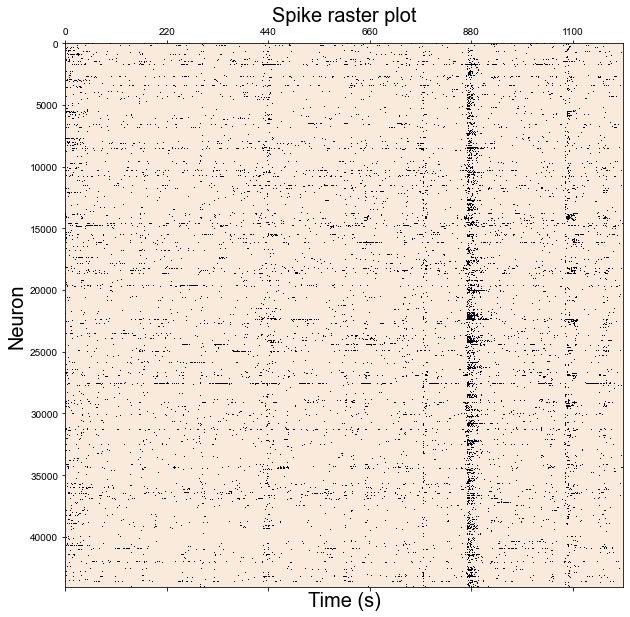

In [2]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style("ticks")
ax.matshow(1-Spikes.T,aspect='auto')
plt.xticks(np.arange(len(Time))[::1000], ['%.f'%t for t in Time[::1000]])
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Neuron',fontsize=20)
plt.title('Spike raster plot',fontsize=20)

## Raw fluorescence signal and corresponding deconvolved spikes for 10 randomly selected neurons
Spike inference was performed using the BSD software: (https://github.com/jertubiana/BSD)

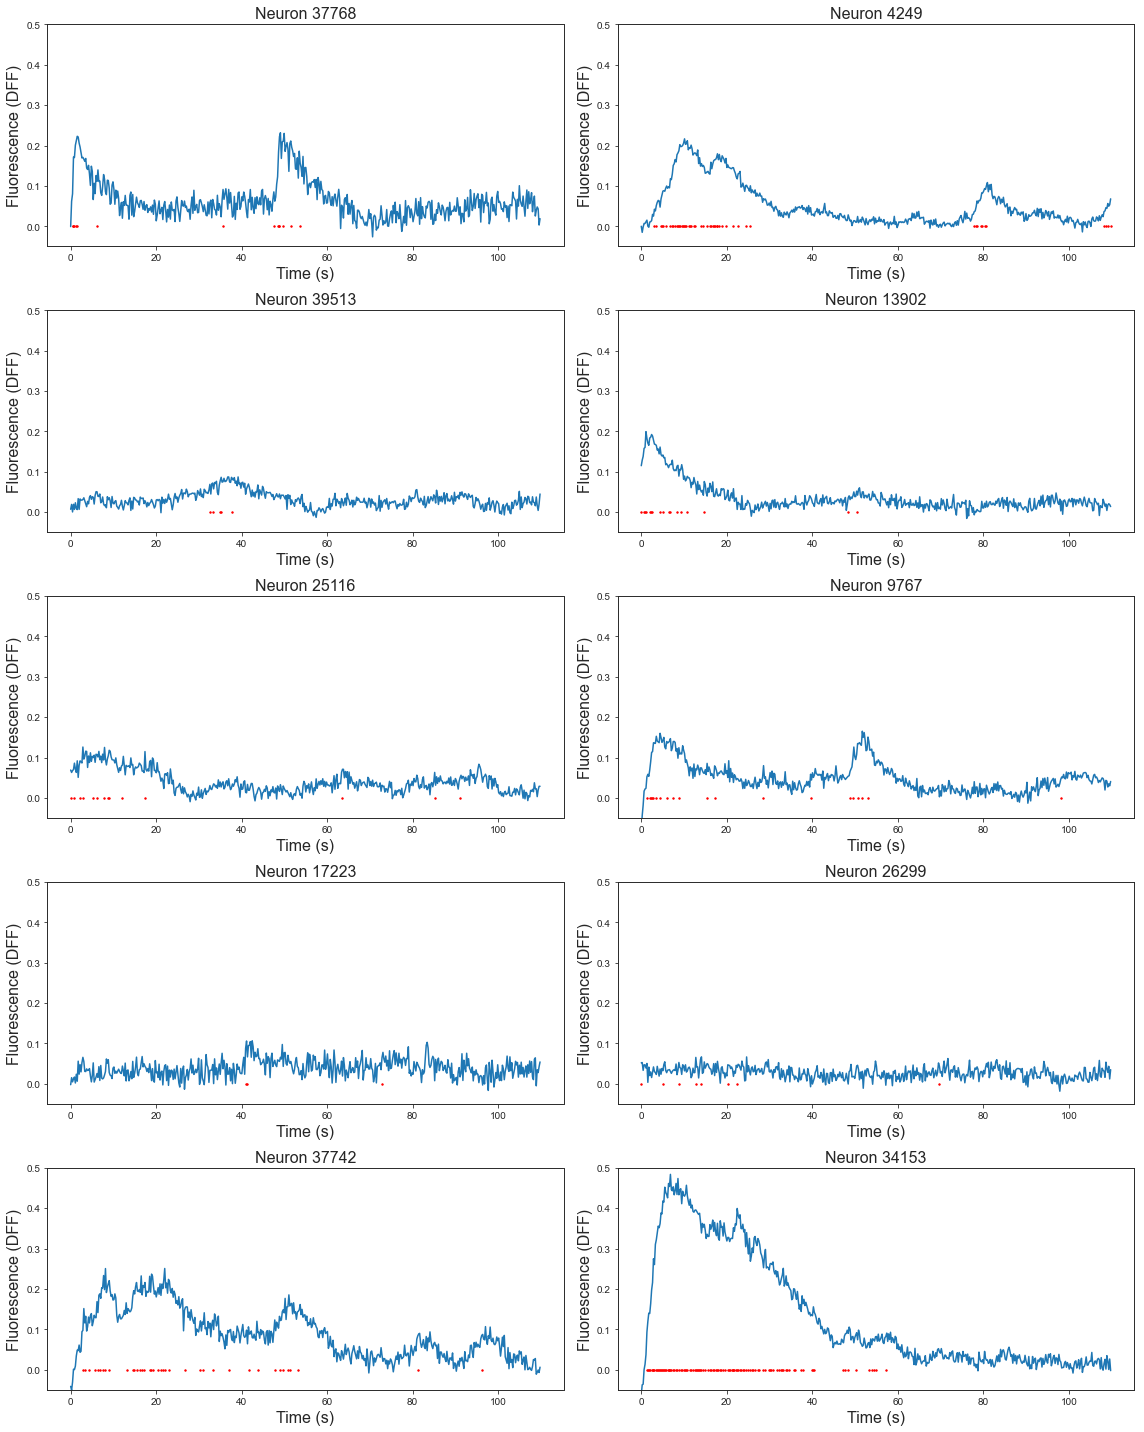

In [3]:

selected_neurons = np.argsort(np.random.randn(nNeurons))[:10]
selected_time_frames = np.arange(500)

fig, ax = plt.subplots(nrows=5,ncols=2, figsize=(2*8,5*4))
for i in range(10):
    selected_neuron = selected_neurons[i]
    ax_ = ax[i%5,i//5]
    ax_.plot(Time[selected_time_frames], Fluorescence[selected_time_frames,selected_neuron])
    ax2 = ax_.twinx()
    frame_firing = np.nonzero(Spikes[selected_time_frames,selected_neuron])[0]
    ax2.scatter( Time[selected_time_frames][frame_firing], np.zeros(len(frame_firing)),c='red',s=2 )
    ax_.set_xlabel('Time (s)',fontsize=16)
    ax_.set_ylabel('Fluorescence (DFF)',fontsize=16)
    ax2.set_yticks([])
    ax_.set_ylim([-0.05,0.5])      
    ax2.set_ylim([-0.1,1.])    
    ax_.set_title('Neuron %s'%selected_neurons[i],fontsize=16)
plt.tight_layout()
    



# 3D-visualization of the recording with Ipyvolume

In [4]:
selected_time_frames = np.arange(100,200)


x = ZBrainCoordinates[:,0][np.newaxis]
y = ZBrainCoordinates[:,1][np.newaxis]
z = ZBrainCoordinates[:,2][np.newaxis]



default_colors = np.array([
    [0.,0.,0.,0.1],
    [1,0,0,1.0]
    
])
color = default_colors[Spikes[selected_time_frames].astype(np.int)]
size = 1

ipv.figure()
s = ipv.scatter(x, y, z, color=color, size=size, marker="sphere")
s.sequence_index = 0
ipv.animation_control(s, interval=50)
ipv.xlim( x.min(),x.max() )
ipv.ylim( y.min(),y.max() )
ipv.zlim( z.min(),z.max() )
ipv.show()

# Training a Compositional Restricted Boltzmann Machine

The model hyperparameters (hidden layer size and sparse weight regularization penalty) and training hyperparameters (learning rate, batch size) are recording-dependent.

- The number of hidden units is roughly proportional to the number of neurons recorded. More neurons are required to model mode neurons. 

- Here, we used a fixed regularization strength lambda1 = 0.02. The regularization strength should be roughly proportional to the average activity observed in recording. Indeed, for recordings with low activity, modeling correlations with weights recordings yield weaker gain in likelihood. A lower regularization must be used to compensate for it and avoid zero-weights solution.

- Learning rate and batch size. Reducing learning rates and increasing batch size (and the number of Markov chains, which equals the batch size in our implementation) tend to stabilize training, but they both require longer trainings. Recordings with activity bursts tend to be harder to train, due to the multimodal nature of data which makes MCMC sampling more challenging.


Importantly, high capacity models (corresponding to low regularization, large number of hidden units) have complex energy landscapes and are therefore harder to train due to the MCMC sampling. Reduce the capacity can facilitate convergence.






In [5]:


if subset:
    n_h = 50 # Number of hidden units.
    l1 = 1e-2 # Sparse regularization strength.
    learning_rate = 1e-4 # Initial learning rate.
    batch_size = 100 # Batch size / number of MCMC chains.
    N_MC = 15  # Number of alternate Gibbs sampling steps performed between each gradient calculation (PCD algorithm)
    n_updates = 50000 # Total number of gradient descent updates performed.
else:
    n_hidden_units = {        
    'fish1_20180706_Run04':200,
    'fish2_20180911_Run01':200,
    'fish3_20180912_Run01':200,
    'fish4_20180913_Run01':200,
    'fish5_20190109_Run04':100,
    'fish6_20181206_Run03':200,
    'fish7_20190102_Run01':100,
    'fish8_20181206_Run05':100,
                    }
    
    learning_rates = {
    'fish1_20180706_Run04':1e-3,
    'fish2_20180911_Run01':1e-3,
    'fish3_20180912_Run01':1e-3,
    'fish4_20180913_Run01':2.5e-4,
    'fish5_20190109_Run04':1e-4,
    'fish6_20181206_Run03':2.5e-4,
    'fish7_20190102_Run01':1e-4,
    'fish8_20181206_Run05':2.5e-4,
    }
    
    batch_sizes = {
    'fish1_20180706_Run04':400,
    'fish2_20180911_Run01':100,
    'fish3_20180912_Run01':100,
    'fish4_20180913_Run01':100,
    'fish5_20190109_Run04':400,
    'fish6_20181206_Run03':100,
    'fish7_20190102_Run01':400,
    'fish8_20181206_Run05':100,
    }    
    n_h = n_hidden_units[dataset] # Number of hidden units.
    l1 = 0.02 # Sparse regularization strength.
    learning_rate = learning_rates[dataset] # Initial learning rate.
    batch_size = batch_sizes[dataset] # Batch size / number of MCMC chains.
    N_MC = 15 # Number of alternate Gibbs sampling steps performed between each gradient calculation (PCD algorithm)
    n_updates = 200000 # Total number of gradient descent updates performed.
    

path2rbm = models_folder + 'rbm_%s.data'%dataset        

if retrain:
    if not subset:
        path2rbm = path2rbm[:-5] + '_retrained.data'
    RBM = rbm.RBM(n_v=nNeurons, # Number of visible units (neurons).
                  n_h = n_h, # Number of hidden units.
                  visible='Bernoulli', # Nature of visible units (Bernoulli = 0/1 values)
                  hidden='dReLU' # Nature of hidden units. double Rectified linear Units potential. hidden='Gaussian' reproduces the Hopfield model.
                 )
    
    n_iter = (n_updates // (Spikes.shape[0] // batch_size))    # Number of epochs
    print('Starting fit, %s epochs' % n_iter)
    RBM.fit(Spikes, 

            l1=l1, # sparse l1 regularization.
            n_iter=n_iter, # Number of epochs.            
            learning_rate=learning_rate, # The learning rate             
            batch_size=batch_size, # Batch size.
            N_MC=N_MC, # Number of MCMC steps.
            verbose=0,             
            vverbose=1,
           )
    print('Finished fit, %s epochs' % n_iter)    
    RBM = RBM_utils.swap_sign_RBM(RBM)
    RBM_utils.saveRBM(path2rbm,RBM)
    
else:
    RBM = RBM_utils.loadRBM(path2rbm)
    RBM = RBM_utils.swap_sign_RBM(RBM)    

# Convergence assessment and quality of fit

- Generate a sample from the learnt probability distribution P(v) via Markov Chain Monte Carlo.
- Calculate moments \<v\>, \<h\>, \<vh\> from data distribution and model distribution.
- Calculate hidden unit covariance \<hh\> -\<h\> \<h\>
- If calculate_cov_vv=True, calculate neuron-neuron covariances \<vv\> -\<v\> \<v\>. Long run time (~5 minutes/ few hours) for subset/full data!!
- Plot comparison and calculate error
- Calculate reconstruction error and show.

If you find weak correlations, this suggests a failed convergence, try rerunning:
- Without any change (training is stochastic and can fail)
- Reducing the learning rate

Mismatch dimensions (400, 200), [200, 200], reinitializating I
Mismatch dimensions (400, 44055), [200, 44055], reinitializating I


../source/layer.py:1188: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)
../source/layer.py:1188: RuntimeWarning: invalid value encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)


Did not assess pairwise correlations


Text(0.5, 0, 'Normalized reconstruction likelihood ($\\in [0,1]$)')

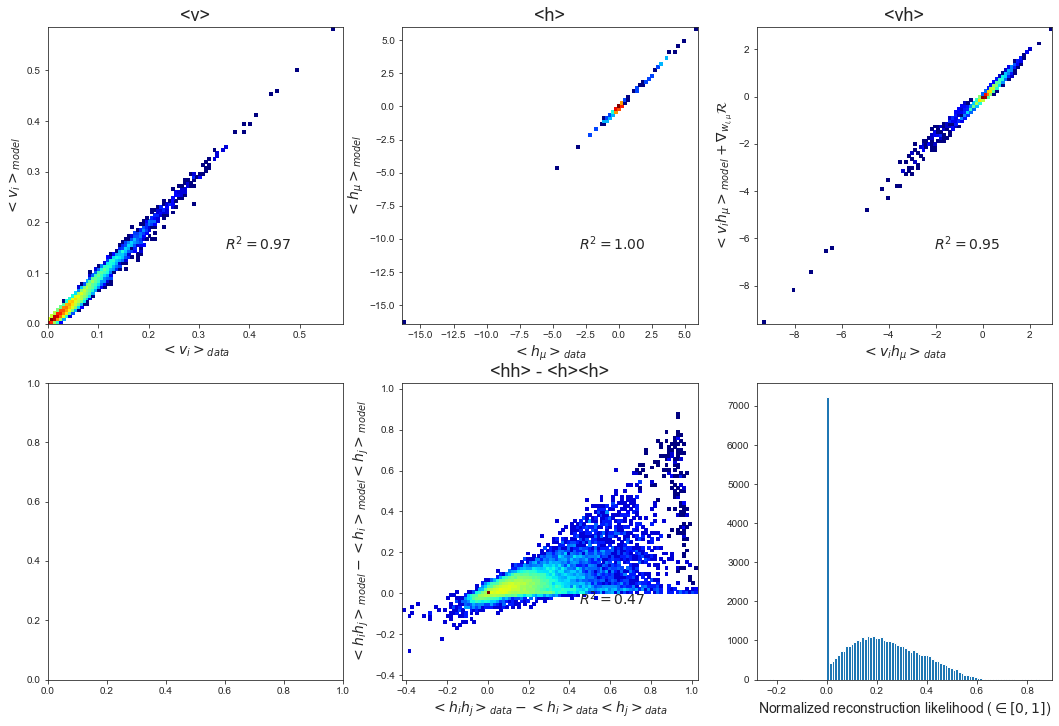

In [6]:
Lchains = 50 # Length of MCMC chains
Nchains = 200 # Number of MCMC chains
Nsteps = 20 # Number of steps between saved MCMC points
Nthermalize = 4000 # Number of burn-in MCMC steps


def calculate_pairwise(v,batch_size=100,verbose=1):
    '''
    This utility calculates np.dot(v_data.T,v_data)/len(v_data)
    Although it shound not be necessary, using mini-batches seems to improve speed...
    
    '''
    nTime,nNeurons = v.shape
    nbatches = int(np.ceil(nTime/batch_size ))
    pairwise = np.zeros([nNeurons,nNeurons],dtype=np.int64)
    for b in range(nbatches):
        mini = b*nbatches
        maxi = min((b+1)*nbatches, len(v_data) )
        pairwise += np.dot(1*v[mini:maxi].T,v[mini:maxi])
        if verbose:
            if b%10==0:
                print('Calculate <vv>, Batch %s/%s' %(b,nbatches) )
    return pairwise.astype(np.float32)/nTime


def jointplot(mu_x,mu_y,
              xlabel,ylabel,
              title,
              ax,fs=14):
    from matplotlib.colors import LogNorm    
    mu_x = mu_x.flatten()
    mu_y = mu_y.flatten()
    
    mini = min(mu_x.min(),mu_y.min())
    maxi = max(mu_x.max(),mu_y.max())
#     ax.plot([mini,maxi],[mini,maxi],c='black',alpha=1.)    
    ax.hist2d(mu_x,mu_y,100,range=[[mini,maxi],[mini,maxi]],
              norm=LogNorm(),cmap='jet')

    ax.set_xlabel(xlabel,fontsize=fs)
    ax.set_ylabel(ylabel,fontsize=fs)    
    ax.set_title(title,fontsize=fs+4)
    r2 = np.corrcoef(mu_x,mu_y )[0,1]**2
    ax.text( 0.6 * maxi + 0.4 * mini,0.25 * maxi + 0.75 * mini,r'$R^2 = %.2f$'%r2,fontsize=fs)
    return
    




calculate_cov_vv = False


v_gen, h_gen = RBM.gen_data(Lchains=Lchains,
                                    Nchains=Nchains,                                    
                                    Nthermalize=Nthermalize,
                                    Nstep = Nsteps) # Generate RBM samples by MCMC
v_gen = v_gen.astype(np.bool)



v_data = Spikes # Rename for clarity.
h_data = RBM.mean_hiddens(v_data) # Calculate latent variable activity 
h_gen = RBM.mean_hiddens(v_gen) # Calculate latent variable activity 


mu_v_data = v_data.mean(0) # <v>_data
mu_v_gen = v_gen.mean(0) # <v>_model

mu_h_data = h_data.mean(0) # <h>_data
mu_h_gen = h_gen.mean(0) # <h>_model

mu_vh_data = np.dot(h_data.T,v_data)/len(v_data) # <vh>_data
mu_vh_gen = np.dot(h_gen.T,v_gen)/len(v_gen) # <vh>_model

regularization_gradient = np.sign(RBM.weights) * RBM.l1 # Gradient w.r.t weights writes <vh>_data - <vh>_model - dR/dw
regularization_mask =  ( np.abs(RBM.weights)>1e-3 ) # KKT convergence conditions with L1 regularization: the gradient is zero only if w <>0. 


if calculate_cov_vv:
    cov_vv_data = calculate_pairwise(v_data) - mu_v_data[np.newaxis] * mu_v_data[:,np.newaxis] # <vv> - <v><v> data
    cov_vv_gen = calculate_pairwise(v_gen) - mu_v_gen[np.newaxis] * mu_v_gen[:,np.newaxis] # <vv> - <v><v> model

cov_hh_data = np.dot(1*h_data.T,h_data)/len(h_data) - mu_h_data[np.newaxis] * mu_h_data[:,np.newaxis] # <hh> - <h><h> data
cov_hh_gen = np.dot(1*h_gen.T,h_gen)/len(h_gen) - mu_h_gen[np.newaxis] * mu_h_gen[:,np.newaxis] # <hh> - <h><h> model




reconstructed_v = RBM.mean_visibles(h_data)
reconstruction_likelihood_data = ( np.log(reconstructed_v+1e-6) * v_data + np.log(1-reconstructed_v+1e-6) * (1-v_data) ).mean(0)
reconstruction_likelihood_baseline =  mu_v_data * np.log(mu_v_data+1e-6) + (1-mu_v_data) * np.log(1-mu_v_data+1e-6)

normalized_reconstruction_likelihood_data = (reconstruction_likelihood_data-reconstruction_likelihood_baseline)/(-reconstruction_likelihood_baseline)


fig, ax = plt.subplots(2,3)
fig.set_figheight(2*6)
fig.set_figwidth(3*6)
fs = 14

jointplot(mu_v_data,
          mu_v_gen,
          r'$<v_i>_{data}$',
          r'$<v_i>_{model}$',
          '<v>',
          ax[0,0],fs=14)


jointplot(mu_h_data,
          mu_h_gen,
          r'$<h_\mu>_{data}$',
          r'$<h_\mu>_{model}$',
          '<h>',
          ax[0,1],fs=14)


jointplot(mu_vh_data[regularization_mask],
          mu_vh_gen[regularization_mask] + regularization_gradient[regularization_mask],
          r'$<v_i h_\mu>_{data}$',
          r'$<v_i h_\mu>_{model} + \nabla_{w_{i,\mu}} \mathcal{R}$',
          '<vh>',
          ax[0,2],fs=14)


if calculate_cov_vv:

    jointplot(cov_vv_data,
              cov_vv_gen,
              r'$<v_i v_j>_{data} - <v_i>_{data}<v_j>_{data}$',
              r'$<v_i v_j>_{model} - <v_i>_{model}<v_j>_{model}$',
              '<vv> - <v><v>',
              ax[1,0],fs=14)    
else:
    print('Did not assess pairwise correlations')

    
jointplot(cov_hh_data,
          cov_hh_gen,
          r'$<h_i h_j>_{data} - <h_i>_{data}<h_j>_{data}$',
          r'$<h_i h_j>_{model} - <h_i>_{model}<h_j>_{model}$',
          '<hh> - <h><h>',
          ax[1,1],fs=14)       


    

ax_ = ax[1,2]
ax_.hist(normalized_reconstruction_likelihood_data,bins=100);
ax_.set_xlabel(r'Normalized reconstruction likelihood ($\in [0,1]$)', fontsize=14)

# Visualization of learnt weights
Show, for each hidden unit the set of neurons with non-zero weights. 
Color coded by values of the  weight matrix entry $w_{i,\mu}$. Red, blue and grey respectively denote positive, negative and zero values.


For advanced visualizations, the Fishualizer package must be downloaded and installed. It is available here: https://bitbucket.org/benglitz/fishualizer_public/



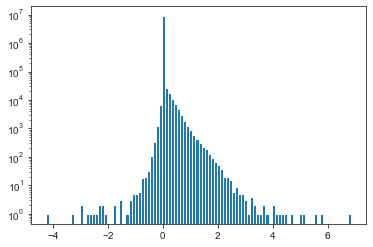

In [7]:
plt.hist(RBM.weights.flatten(), bins = 100,log=True );
selected_hidden_units = np.arange(n_h)


x = ZBrainCoordinates[:,0][np.newaxis]
y = ZBrainCoordinates[:,1][np.newaxis]
z = ZBrainCoordinates[:,2][np.newaxis]


w_max = 0.5
w_cutoff = w_max/10


red_color = np.array([1.,0.,0.,1.])
blue_color = np.array([0.,0.,1.,1.])

if subset:
    background_transparency = 0.1
else:
    background_transparency = 0.05


colors = []
for mu in selected_hidden_units:
    W = RBM.weights[mu]
    color = np.zeros([nNeurons,4])
    color += red_color[np.newaxis] *  np.clip( (W>=w_cutoff)  * (W-w_cutoff)/(w_max-w_cutoff),0, 1)[:,np.newaxis]
    color += blue_color[np.newaxis] * np.clip( (W<=-w_cutoff)  * 2 * (-W+w_cutoff)/(w_max-w_cutoff),0, 1)[:,np.newaxis]
    color[:,3] = np.maximum(color[:,3],background_transparency)
    colors.append(color)


colors = np.array(colors)



size = 1

ipv.figure()
s = ipv.scatter(x, y, z, color=colors, size=size, marker="sphere")
s.sequence_index = 0
ipv.animation_control(s, interval=400)
ipv.xlim( x.min(),x.max() )
ipv.ylim( y.min(),y.max() )
ipv.zlim( z.min(),z.max() )
ipv.show()

# Functional connectivity inference
Neurons interact with one another indirectly via the hidden layer. RBM can be used to reconstruct a neuron-to-neuron effective connectivity matrix. The connectivity matrix has a low rank, equal to the number of hidden units.


The 3D-visualization plot depicts for a given neuron (shown as a green dot) the set of connected neurons, with red/bleu denoting excitatory/inhibitory connections


In [8]:
J = RBM_utils.get_effective_couplings_approx(RBM,Spikes)

subset_neurons = np.random.randint(0,high=nNeurons,size=200)

x = ZBrainCoordinates[:,0][np.newaxis]
y = ZBrainCoordinates[:,1][np.newaxis]
z = ZBrainCoordinates[:,2][np.newaxis]


w_max = np.quantile(J.flatten(),0.999)
w_cutoff = w_max/10

red_color = np.array([1.,0.,0.,1.])
blue_color = np.array([0.,0.,1.,1.])
background_transparency = 0.1


colors = []
for neuron in subset_neurons:
    W = J[neuron]
    color = np.zeros([nNeurons,4])
    color += red_color[np.newaxis] *  np.clip( (W>=w_cutoff)  * (W-w_cutoff)/(w_max-w_cutoff),0, 1)[:,np.newaxis]
    color += blue_color[np.newaxis] * np.clip( (W<=-w_cutoff)  * 2 * (-W+w_cutoff)/(w_max-w_cutoff),0, 1)[:,np.newaxis]
    color[:,3] = np.maximum(color[:,3],background_transparency)
    color[neuron] = np.array([0,1.0,0.,1.0])
    colors.append(color)


colors = np.array(colors)


size = 1

ipv.figure()
s = ipv.scatter(x, y, z, color=colors, size=size, marker="sphere")
s.sequence_index = 0
ipv.animation_control(s, interval=1000)
ipv.xlim( x.min(),x.max() )
ipv.ylim( y.min(),y.max() )
ipv.zlim( z.min(),z.max() )
ipv.show()






../source/layer.py:1225: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)
../source/layer.py:1225: RuntimeWarning: invalid value encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)


# Region to region connectivity matrix
In this section, we aggregate the connectivity matrix at the region level. 
We first assign a region to each neuron using the zbrain atlas mapping). Next, we select the regions that are sufficiently sampled by the recording. Finally, we aggregate the connectivity matrix at the region level by taking the root mean square of the matrix entries:

$$J^\mathcal{R}_{mn} = \sqrt{  \frac{\sum_{i,j, i \in \mathcal{R}_m, j \in \mathcal{R}_m } J_{ij}^2 }{\sum_{i,j, i \in \mathcal{R}_m, j \in \mathcal{R}_m } 1 } }$$

List of Zbrain regions sufficiently represented in recording:
Region Diencephalon_Left, N=839 neurons
Region Diencephalon_Right, N=1129 neurons
Region Mesencephalon_Left, N=8360 neurons
Region Mesencephalon_Right, N=8103 neurons
Region Rhombencephalon_Left, N=12492 neurons
Region Rhombencephalon_Right, N=12215 neurons
Region Telencephalon_Left, N=329 neurons
Region Telencephalon_Right, N=572 neurons


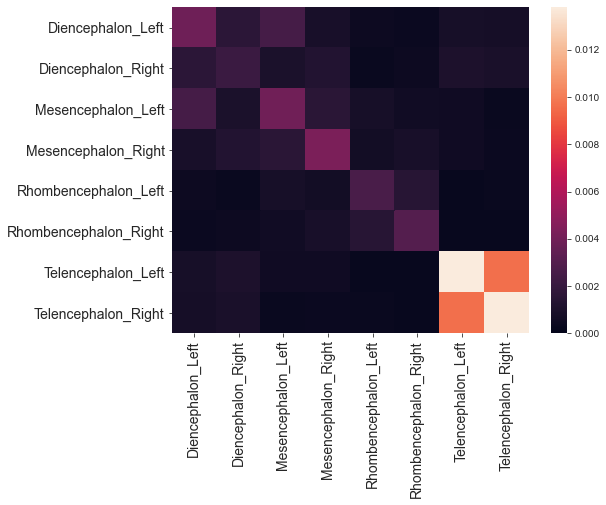

In [9]:
from numba import njit,prange


def construct_zbrain_labels(
    ZBrainCoordinates, Labels,
    coarse=True,atlas_folder=atlas_folder):

    def get_zbrain_regions(file,coarse=False):
        list_regions = []
        with open(file,'r') as f:
            for line in f:
                list_regions.append(line[:-1])
        if coarse:
            list_regions = list(map(lambda x: x.split(' -')[0],list_regions))
            list_regions,mapping = np.unique(list_regions, return_inverse=True)
        else:
            mapping = np.arange(len(list_regions))
        return list_regions,mapping

    def is_left_right(ZBrainCoordinates):
        median = np.median(ZBrainCoordinates[:,0])
        return 1*(ZBrainCoordinates[:,0]>=median)

    file = atlas_folder + 'ZbrainRegions.txt'
    orphan_neurons = Labels.max(-1)==0
    zbrain_regions = np.argmax(Labels,axis=-1)
    list_regions,full_to_coarse_mapping = get_zbrain_regions(file,coarse=True)
    left_right = is_left_right(ZBrainCoordinates)
    zbrain_regions = 2*full_to_coarse_mapping[zbrain_regions]+ left_right
    zbrain_regions[orphan_neurons] = -1
    
    tmp = []
    for region in list_regions:
        tmp.append(region+'_Left')
        tmp.append(region+'_Right')
    list_regions = np.array(tmp)
    return zbrain_regions, list_regions



@njit(parallel=True)
def aggregate_couplings(M, partition, npartition, power=2):
    nNeurons = M.shape[0]
    Magg = np.zeros((npartition, npartition))
    count = np.zeros((npartition, npartition))
    for i1 in prange(nNeurons):
        for i2 in prange(nNeurons):
            p1 = partition[i1]
            p2 = partition[i2]
            if i1 > i2:
                if (p1 >= 0) & (p2 >= 0):
                    Magg[p1, p2] += np.abs(M[i1, i2])**power
                    count[p1, p2] += 1
    Magg += Magg.T
    count += count.T
    return (Magg / (count + 1e-4))**(1.0 / power)


zbrain_regions, list_regions = construct_zbrain_labels(ZBrainCoordinates,Labels,coarse=True) 
'''
This function assigns a region to each neuron based on the Zbrain atlas.

'''

nregions = len(list_regions)
J_regions = aggregate_couplings(J,zbrain_regions,nregions)

count_regions = np.array([(zbrain_regions==n).sum() for n in range(nregions)])
Nmin = 10

sufficiently_sampled_regions = []

for n in range(nregions):
    if n%2 == 0: # left
        sufficiently_sampled_region = (count_regions[n]>=Nmin) & (count_regions[n+1]>=Nmin)
    else:
        sufficiently_sampled_region = (count_regions[n]>=Nmin) & (count_regions[n-1]>=Nmin)
    sufficiently_sampled_regions.append(sufficiently_sampled_region)
sufficiently_sampled_regions = np.array(sufficiently_sampled_regions)


count_regions = count_regions[sufficiently_sampled_regions]
list_regions = list_regions[sufficiently_sampled_regions]
J_regions = J_regions[sufficiently_sampled_regions,:][:,sufficiently_sampled_regions]


print('List of Zbrain regions sufficiently represented in recording:')
for region,count in zip(list_regions,count_regions):
    print('Region %s, N=%s neurons' %(region,count))

vmin = 0
vmax = 3 * np.sqrt( (J_regions**2).mean()) 
    
fig, ax = plt.subplots(figsize=(8,6));
sns.heatmap(J_regions, xticklabels=list_regions, yticklabels=list_regions,vmin=vmin,vmax=vmax,ax=ax);
plt.xticks(rotation=90);
plt.yticks(rotation=0);

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)





# Comparison with the structural connectivity matrix from Kunst et al. 2019
To compare our region-to-region functional connectivity matrix to the mesoscale structural connectivity matrix derived from traced neurites by Kunst et al. 2019, we need to map the MPIN atlas to our data. Then, the same protocol is followed.

Constructing mapping between Zbrain and MPINbrain atlas.
A few reflexions/rotations are possible... Enumerating and keeping the one with highest percentage of mapped neurons
85 percent of the neurons were mapped
List of MPINbrain regions sufficiently represented in recording:
Region cerebellum_left
, N=1730 neurons
Region cerebellum_right
, N=1660 neurons
Region habenula_left
, N=182 neurons
Region habenula_right
, N=240 neurons
Region intermediate_reticular_formation_left
, N=98 neurons
Region intermediate_reticular_formation_right
, N=220 neurons
Region medial_octavolateral_nucleus_left
, N=1327 neurons
Region medial_octavolateral_nucleus_right
, N=1195 neurons
Region MO_stripe_1_left
, N=732 neurons
Region MO_stripe_1_right
, N=825 neurons
Region MO_stripe_2_left
, N=834 neurons
Region MO_stripe_2_right
, N=991 neurons
Region MO_stripe_3_left
, N=862 neurons
Region MO_stripe_3_right
, N=708 neurons
Region MO_stripe_4_left
, N=1650 neurons
Region MO_stripe_4_right
, N=1432 neurons
Re

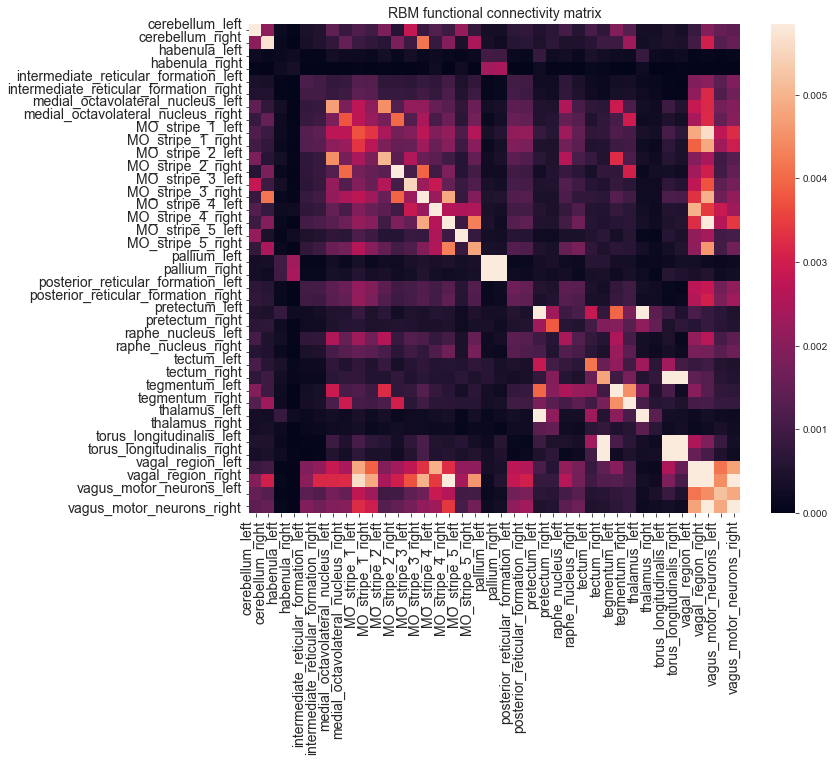

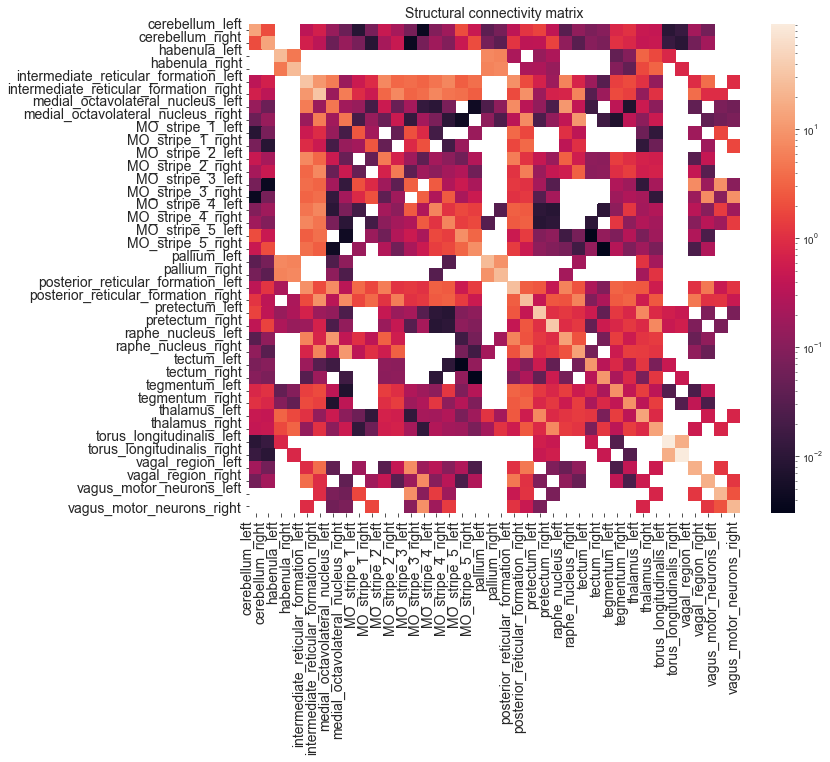

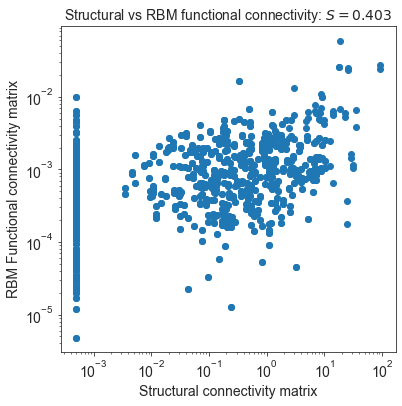

In [13]:
import copy
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import spearmanr

def construct_mpin_labels(
    ZBrainCoordinates, Labels,
    coarse=True,
    first_swap = False,
    second_swap = False,
    third_swap = False,
    atlas_folder=atlas_folder):

    '''
    Step #1: discretize ZbrainCoordinates into voxels.
    Assuming(!) that coordinates is already in the same space as the ZBrainAtlas,
    one can find the closest voxel center per coordinate (i.e. the voxel that contains the coordinate).
    Transform coordinates to their (element-wise) nearest point in grid.
    ''' 
    
    zbrain_resolution = np.array([0.798, 0.798, 2]) ## Resolution from ZBrainAtlas doc in um
    grid_coordinates = np.round(ZBrainCoordinates * 1000 / zbrain_resolution); ## Find closest voxel per coordinate
    grid_coordinates = grid_coordinates.astype('int')    
    # Calculates the data coordinates expressed in the ZBrainAtlas grid (go to um and apply resolution transformation)

    
    '''
    Step #2: Map to the MPIN brain region. baier_ref is a 3D grid with per-label.
    Note that there can be a rotation/reflexion w.r.t to the dataset depending on the recording.
    Check out swap1,swap2 = True/False.
    '''     
    
    file = atlas_folder + 'Combined_regions_MPIN_to_zbrain_labeled_matfile.mat'
    mat = loadmat(file)
    baier_ref = mat['imageStack']
    # define number of dimensions    
    n_x = baier_ref.shape[0]
    n_y = baier_ref.shape[1]
    n_z = baier_ref.shape[2]
    # swap axes (determined by visual inspection in fishualizer)
    if first_swap:
        grid_coordinates = grid_coordinates[:, [1, 0, 2]] # reorientate x and y axis determined after visual inspection 11/06/2018)    
    if second_swap:
        grid_coordinates[:, 0] = n_x - grid_coordinates[:, 0] # swap new x coordinates left to right (check in fishualizer!, or x coordinates of labels left hab and right hab in zbrain labelling)
    if third_swap:
        grid_coordinates[:, 2] = n_z - grid_coordinates[:, 2] # swap new z coordinates (because baier ref is essentially upside odwn)    

    ## Label neurons according to Baier atlas

    grid_labels = np.zeros(grid_coordinates.shape[0],dtype=np.int)  # zero = not labelled
    for n in range(grid_coordinates.shape[0]):
        try:
            grid_labels[n] = baier_ref[grid_coordinates[n, 0], grid_coordinates[n, 1], grid_coordinates[n, 2]]
            # label by inserting grid coordinates in baier atlas to obtain unique label at that point
        except:
            continue # Some neurons are outside of the zbrain space limit.

    ## Determine whether left or right
    right_bool = np.zeros(grid_coordinates.shape[0],dtype=np.int)
    ## check in fishualizer: x: L -> R
    x_med = int(0.5 * baier_ref.shape[0])  # median
    right_bool[grid_coordinates[:, 0] > x_med] = 1  # greater than median = RIGHT
    mpin_regions = 2 * grid_labels - 1 
    mpin_regions[mpin_regions < 0] = 0
    mpin_regions[mpin_regions != 0] += right_bool[mpin_regions != 0]
    mpin_regions -= 1
    
    
    list_regions = []
    with open(atlas_folder+'MPINRegions.txt','r') as f:
        for line in f:
            list_regions.append(line)
    list_regions = np.array(list_regions)
    return mpin_regions,list_regions

best_mpin_regions = None
best_fraction_mapped = 0

print('Constructing mapping between Zbrain and MPINbrain atlas.')
print('A few reflexions/rotations are possible... Enumerating and keeping the one with highest percentage of mapped neurons')
for first_swap in [False]:
    for second_swap in [False,True]:
        for third_swap in [False,True]:        
            mpin_regions,list_regions = construct_mpin_labels(
                ZBrainCoordinates, Labels,
                coarse=True,
                first_swap = first_swap,
                second_swap = second_swap,
                third_swap = third_swap,
                atlas_folder=atlas_folder)
            fraction_mapped = (mpin_regions>=0).mean()
            if fraction_mapped>=best_fraction_mapped:
                best_fraction_mapped = copy.copy(fraction_mapped)
                best_mpin_regions = mpin_regions.copy()

mpin_regions = best_mpin_regions
print('%.f percent of the neurons were mapped'% (100*best_fraction_mapped ) )




nregions = len(list_regions)
J_regions = aggregate_couplings(J,mpin_regions,nregions)


if calculate_cov_vv:
    J_regions_covariance = aggregate_couplings(cov_vv_data,mpin_regions,nregions)


J_structural_regions = np.array(pd.read_csv(atlas_folder+'structural_connectivity_kunst.csv',index_col='Unnamed: 0') )


count_regions = np.array([(mpin_regions==n).sum() for n in range(nregions)])
Nmin = 10

sufficiently_sampled_regions = []

for n in range(nregions):
    if n%2 == 0: # left
        sufficiently_sampled_region = (count_regions[n]>=Nmin) & (count_regions[n+1]>=Nmin)
    else:
        sufficiently_sampled_region = (count_regions[n]>=Nmin) & (count_regions[n-1]>=Nmin)
    sufficiently_sampled_regions.append(sufficiently_sampled_region)
sufficiently_sampled_regions = np.array(sufficiently_sampled_regions)


count_regions = count_regions[sufficiently_sampled_regions]
list_regions = list_regions[sufficiently_sampled_regions]
J_regions = J_regions[sufficiently_sampled_regions,:][:,sufficiently_sampled_regions]
if calculate_cov_vv:
    J_regions_covariance = J_regions_covariance[sufficiently_sampled_regions,:][:,sufficiently_sampled_regions]

J_structural_regions = J_structural_regions[sufficiently_sampled_regions,:][:,sufficiently_sampled_regions]



print('List of MPINbrain regions sufficiently represented in recording:')
for region,count in zip(list_regions,count_regions):
    print('Region %s, N=%s neurons' %(region,count))

vmin = 0
vmax = 2 * np.sqrt( (J_regions**2).mean()) 
    
if subset:
    fig, ax = plt.subplots(figsize=(8,6));
else:
    fig, ax = plt.subplots(figsize=(11,9));
sns.heatmap(J_regions, xticklabels=list_regions, yticklabels=list_regions,vmin=vmin,vmax=vmax,ax=ax);
plt.xticks(rotation=90);
plt.yticks(rotation=0);
plt.title('RBM functional connectivity matrix')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.show()



    
vmin = 0
vmax = 2 * np.sqrt( (J_structural_regions**2).mean()) 
    
    
if subset:
    fig, ax = plt.subplots(figsize=(8,6));
else:
    fig, ax = plt.subplots(figsize=(11,9));    
sns.heatmap(J_structural_regions, xticklabels=list_regions, yticklabels=list_regions,vmin=vmin,vmax=vmax,ax=ax,
           norm=LogNorm())
plt.xticks(rotation=90);
plt.yticks(rotation=0);
plt.title('Structural connectivity matrix')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.show()

    


    
    
scale_functional = np.sqrt( (J_regions**2).mean() )
scale_structural = np.sqrt( (J_structural_regions**2).mean() )
spearman = spearmanr(J_regions.flatten(),J_structural_regions.flatten()).correlation


fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(1e-4 * scale_structural+J_structural_regions.flatten(), 1e-4 * scale_functional +J_regions.flatten() )
plt.title('Structural vs RBM functional connectivity: $S= %.3f$' % spearman)
plt.xlabel('Structural connectivity matrix' )
plt.ylabel('RBM Functional connectivity matrix' )
plt.xscale('log')
plt.yscale('log')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

if calculate_cov_vv:
    print('Also comparing with functional connectivity matrix derived from covariance matrix...')    
    

    vmin = 0
    vmax = 2 * np.sqrt( (J_regions_covariance**2).mean()) 

    if subset:
        fig, ax = plt.subplots(figsize=(8,6));
    else:
        fig, ax = plt.subplots(figsize=(11,9));    
    sns.heatmap(J_regions_covariance, xticklabels=list_regions, yticklabels=list_regions,vmin=vmin,vmax=vmax,ax=ax);
    plt.xticks(rotation=90);
    plt.yticks(rotation=0);
    plt.title('Covariance-derived functional connectivity matrix')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    plt.show()


    scale_functional = np.sqrt( (J_regions_covariance**2).mean() )
    scale_structural = np.sqrt( (J_structural_regions**2).mean() )
    spearman = spearmanr(J_regions_covariance.flatten(),J_structural_regions.flatten()).correlation

    fig, ax = plt.subplots(figsize=(6,6))
    plt.scatter(1e-4 * scale_structural+J_structural_regions.flatten(), 1e-4 * scale_functional +J_regions_covariance.flatten() )
    plt.title('Structural vs covariance functional connectivity: $S= %.3f$' % spearman)
    plt.xlabel('Structural connectivity matrix' )
    plt.ylabel('Covariance Functional connectivity matrix' )
    plt.xscale('log')
    plt.yscale('log')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)    



# Exporting data to Fishualizer
Assemblies are best visualized in the Fishualizer developed by Thijs van der Plas et al.

In [ ]:
os.chdir(path2fishualizer)
from fishualizer_utilities import Zecording
import pandas as pd
import scipy.sparse



def export_weights_for_fishualizer(rbm, recording_path, 
                                   labeled_cells_only=True,
                                   path_weights='/home/thijs/',
                                   filename_weights='weights_RBM-name.h5',
                                   save_h5=True):
    '''Export weights from RBM to file compatible with fishualizer viewing.
    
    Parameters:
    ---------
        rbm: RBM class
            RBM object with weights to be exported
        recording: Zecording class
            Zecording object (from Fishualizer) that contains zebrafish data recording on which this rbm has been trained'
        labeled_cells_only: bool
            If the RBM has been trained on the Zbrain Atlas-labeled cells only; then we need to account for this when exporting the weights
        path_weights: str
            folder 
        filename_weights: str
            file name 
    '''
    
    if filename_weights[-3:] != '.h5':
        filename_weights = filename_weights + '.h5'
        
    ## Extract RBM weights:
    weights = np.transpose(RBM.weights)
    
    recording = Zecording(path=recording_path,
                          kwargs={'ignorelags': True,
                                  'forceinterpolation': False,
                                  'ignoreunknowndata': True,# 'parent': self,
                                  'loadram': True})
    
    ## Take care of unlabeled cells if needed
    if labeled_cells_only:
        assert recording != None, 'the zebrafish recording is needed to account for labeled cells only weights'
        n_cells = recording.n_cells
        selected_neurons = np.unique(scipy.sparse.find(recording.labels[:, np.arange(294)])[0])  # cells with zbrain label
        assert weights.shape[0] == len(selected_neurons)  # make sure shape is neurons x time (RBM has only used labelled neurons)
        print(f'n cells: {n_cells}, n labelled cells: {len(selected_neurons)}')
        full_weights = np.zeros((n_cells, weights.shape[1]), dtype='float32')  # make matrix for all cells (including non-labeled)
        full_weights[selected_neurons, :] = weights  # let non-labelled neurons have w=0 for all HU
    else:
        print('Assuming that all cells were used for RBM training')
        full_weights = weights.copy()
        
    ## Export to h5 via pd DataFrame
    df_weights = pd.DataFrame({'hu_' + str(ii).zfill(3):
                                np.squeeze(full_weights[:, ii]) for ii in range(full_weights.shape[1])})  # save as pd df with each column = one weight vector
    if save_h5:
        df_weights.to_hdf(os.path.join(path_weights, filename_weights), key='all')  # store as h5 file
    recording.close()
    message = '''
     Neural assemblies saved!
     To view the weights in the Fishualizer: 
     1/ Launch the Fishualizer
     2/ Load the main data set (= rec) using File -> Open data
     3/ Load the saved weights (= df_weights) using File -> Add static data -> Choose Dataset
     '''
    print(message)
    return df_weights




filename_weights = 'weights_rbm_%s' % dataset +  ('_Rh1' if subset else '') + ('_retrained' if retrain else '') + '.h5'


df_weights = export_weights_for_fishualizer(rbm, recording_path=path2dataset, 
                                   labeled_cells_only=True,
                                   path_weights=path_weights,
                                   filename_weights=filename_weights,
                                   save_h5=True)
